In [1]:
import tensorflow as tf
import utilities as ut
import importlib
from tensorflow import keras
from tensorflow.keras.layers import Concatenate, Dense, GlobalAveragePooling2D, Input, Conv3D, MaxPool3D, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.models import Sequential
from keras_preprocessing.image import array_to_img, img_to_array, load_img
from gen import FrameGenerator
import os
from keras.layers import Lambda, Dense, LSTM,Flatten, TimeDistributed, Conv2D, Dropout
import pandas as pd
import cv2 
import numpy as np

In [2]:
Input_Layer = Input(shape=(64,224,224,5),name='Input Layer') 
#RGB Stream
RGB_Layer1 = Lambda(lambda x: x[:,:,:,:,:3])(Input_Layer)
RGB_Layer2 = Conv3D(filters=16, kernel_size=(1,3,3),activation='relu')(RGB_Layer1)
RGB_Layer3 = Conv3D(filters=16, kernel_size=(3,1,1),activation='relu')(RGB_Layer2)
RGB_Layer4 = MaxPool3D((1,2,2))(RGB_Layer3)
RGB_Layer5 = Conv3D(filters=16, kernel_size=(1,3,3),activation='relu')(RGB_Layer4)
RGB_Layer6 = Conv3D(filters=16, kernel_size=(3,1,1),activation='relu')(RGB_Layer5)
RGB_Layer7 = MaxPool3D((1,2,2))(RGB_Layer6)

RGB_Layer8 = Conv3D(filters=32, kernel_size=(1,3,3),activation='relu')(RGB_Layer7)
RGB_Layer9 = Conv3D(filters=32, kernel_size=(3,1,1),activation='relu')(RGB_Layer8)
RGB_Layer10 = MaxPool3D((1,2,2))(RGB_Layer9)
RGB_Layer11 = Conv3D(filters=32, kernel_size=(1,3,3),activation='relu')(RGB_Layer10)
RGB_Layer12 = Conv3D(filters=32, kernel_size=(3,1,1),activation='relu')(RGB_Layer11)
RGB_Layer13 = MaxPool3D((1,2,2))(RGB_Layer12)

#Optical Flow Stream
Flow_Layer1 = Lambda(lambda x: x[:,:,:,:,:3])(Input_Layer)
Flow_Layer2 = Conv3D(filters=16, kernel_size=(1,3,3),activation='relu')(Flow_Layer1)
Flow_Layer3 = Conv3D(filters=16, kernel_size=(3,1,1),activation='relu')(Flow_Layer2)
Flow_Layer4 = MaxPool3D((1,2,2))(Flow_Layer3)
Flow_Layer5 = Conv3D(filters=16, kernel_size=(1,3,3),activation='relu')(Flow_Layer4)
Flow_Layer6 = Conv3D(filters=16, kernel_size=(3,1,1),activation='relu')(Flow_Layer5)
Flow_Layer7 = MaxPool3D((1,2,2))(Flow_Layer6)

Flow_Layer8 = Conv3D(filters=32, kernel_size=(1,3,3),activation='relu')(Flow_Layer7)
Flow_Layer9 = Conv3D(filters=32, kernel_size=(3,1,1),activation='relu')(Flow_Layer8)
Flow_Layer10 = MaxPool3D((1,2,2))(Flow_Layer9)
Flow_Layer11 = Conv3D(filters=32, kernel_size=(1,3,3),activation='sigmoid')(Flow_Layer10)
Flow_Layer12 = Conv3D(filters=32, kernel_size=(3,1,1),activation='sigmoid')(Flow_Layer11)
Flow_Layer13 = MaxPool3D((1,2,2))(Flow_Layer12)


#Fusion and Pooling
Fusion_Layer = Multiply()([RGB_Layer13,Flow_Layer13])
Pool = MaxPool3D((8,1,1))(Fusion_Layer)

#Merging Block
Merge_Layer_2 = Conv3D(filters=64, kernel_size=(1,3,3),activation='relu')(Pool)
Merge_Layer_3 = Conv3D(filters=64, kernel_size=(3,1,1),activation='relu')(Merge_Layer_2)
Merge_Layer_4 = MaxPool3D((2,2,2))(Merge_Layer_3)
Merge_Layer_5 = Conv3D(filters=64, kernel_size=(1,3,3),activation='relu')(Merge_Layer_4)
Merge_Layer_6 = Conv3D(filters=64, kernel_size=(3,1,1),activation='relu')(Merge_Layer_5)
Merge_Layer_7 = MaxPool3D((2,2,2))(Merge_Layer_6)

Merge_Layer_2_2 = Conv3D(filters=128, kernel_size=(1,3,3),activation='relu')(Merge_Layer_7)
Merge_Layer_2_3 = Conv3D(filters=128, kernel_size=(3,1,1),activation='relu')(Merge_Layer_2_2)
Merge_Layer_2_4 = MaxPool3D((2,2,2))(Merge_Layer_2_3)
Merge_Layer_2_5 = Conv3D(filters=128, kernel_size=(1,3,3),activation='relu')(Merge_Layer_2_4)
Merge_Layer_2_6 = Conv3D(filters=128, kernel_size=(3,1,1),activation='relu')(Merge_Layer_2_5)
Merge_Layer_2_7 = MaxPool3D((2,2,2))(Merge_Layer_2_6)

#Fully Connected Layers
FC_1 = Flatten()(Merge_Layer_2_7)
FC_2 = Dense(128,activation='relu')
FC_3 = Dropout(0)(FC_2)
FC_4 = Dense(32,activation='relu')
output = Dense(2,activation='softmax')

model = Model(inputs=Input_Layer,outputs=output)

ValueError: Exception encountered when calling layer "conv3d_19" (type Conv3D).

Negative dimension size caused by subtracting 3 from 2 for '{{node conv3d_19/Conv3D}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](Placeholder, conv3d_19/Conv3D/ReadVariableOp)' with input shapes: [?,2,3,3,64], [3,1,1,64,64].

Call arguments received by layer "conv3d_19" (type Conv3D):
  • inputs=tf.Tensor(shape=(None, 2, 3, 3, 64), dtype=float32)

In [4]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input Layer (InputLayer)       [(None, 64, 224, 22  0           []                               
                                4, 5)]                                                            
                                                                                                  
 lambda_2 (Lambda)              (None, 64, 224, 224  0           ['Input Layer[0][0]']            
                                , 3)                                                              
                                                                                                  
 lambda_3 (Lambda)              (None, 64, 224, 224  0           ['Input Layer[0][0]']            
                                , 3)                                                          

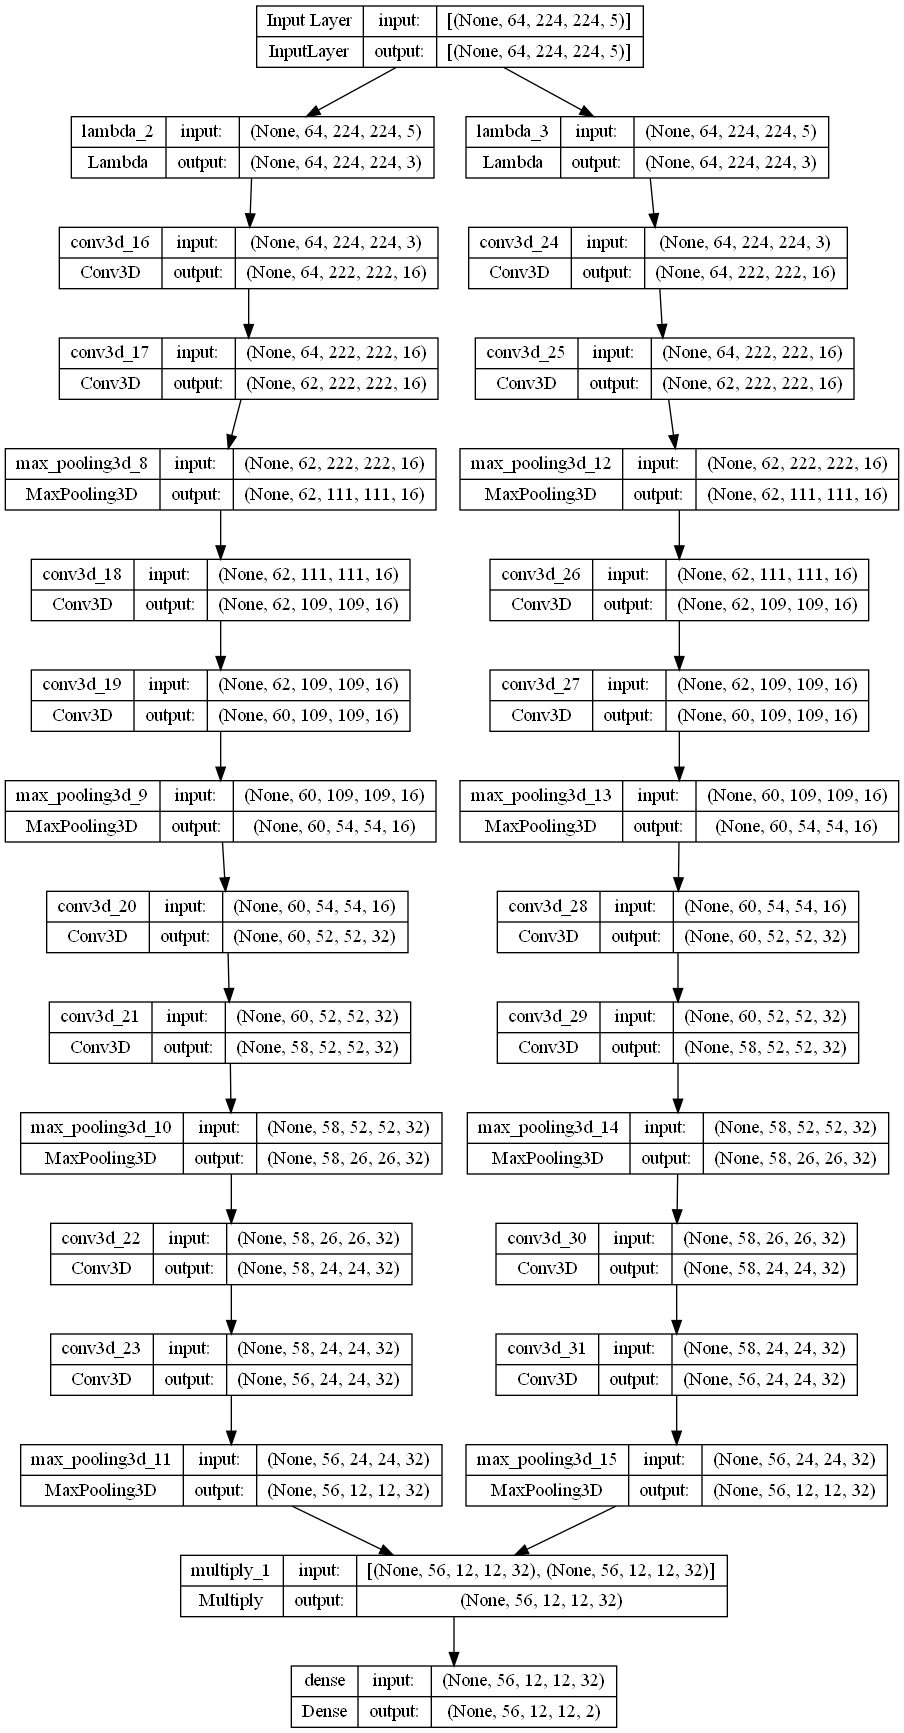

In [5]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plotasd.png', show_shapes=True, show_layer_names=True)

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input Layer (InputLayer)       [(None, 64, 224, 22  0           []                               
                                4, 5)]                                                            
                                                                                                  
 lambda_2 (Lambda)              (None, 64, 224, 224  0           ['Input Layer[0][0]']            
                                , 3)                                                              
                                                                                                  
 lambda_3 (Lambda)              (None, 64, 224, 224  0           ['Input Layer[0][0]']            
                                , 2)                                                          

In [3]:
#merged = Concatenate([model_1,model_2],input_shape=(64,224,224,5))

In [6]:
full_model = Sequential()
#input_layer = tf.keras.layers.Input(shape=(64,224,224,5),name='Input Layer')
#full_model.add(input_layer)
full_model.add(Concatenate([Lambda(lambda x: x[:,:,:,:,:3]),Lambda(lambda x: x[:,:,:,:,:5])],input_shape=(64,224,224,5)))

ValueError: A `Concatenate` layer should be called on a list of at least 1 input. Received: input_shape=(None, 64, 224, 224, 5)

In [10]:
full_model.build(input_shape=(None,64,224,224,5))

ValueError: A `Concatenate` layer should be called on a list of at least 1 input. Received: input_shape=(None, 64, 224, 224, 5)

In [8]:
full_model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.